## 5.4 컨브넷 학습 시각화

사용이 편하고 유용한 세가지 시각화 기법

* 컨브넷 중간층의 출력을 시각화 : 연속된 컨브넷 층이 입력을 어떻게 변형시키는지 이해하고 개별적인 컨브넷 필터의 의미를 파악<br>
* 컨브넷 필터를 시각화 : 커늡넷의 필터가 찾으려는 시각적인 패턴과 개념이 무엇인지 상세하게 이해<br>
* 클래스 활성화에 대한 히트맵을 이미지에 시각화 : 이미지의 어느 부분이 주어진 클래스에 속하는데 기여했는지 이해하고 이미지에서 객체 위치를 추정<br>


### 5.4.1 중간층의 활성화 시각화

In [1]:
from tensorflow.keras.models import load_model
model = load_model('C:/datasets/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 128)      

### 코드 5-25 개별 이미지 전처리

In [2]:
img_path = "C:/datasets/cats_and_dogs_small/test/cats/cat.1700.jpg"

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)

# 이미지를 4D 텐서로 변경
img_tensor = np.expand_dims(img_tensor, axis=0)

# 모델이 훈련될 떄 입력에 적용한  전처리 방식을 동일하게 사용
img_tensor /= 255.

# 이미지 텐서의 크기는 (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


### 코드 5-26 테스트 사진 출력

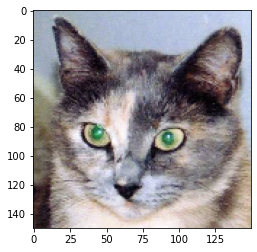

In [3]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

### 코드 5-27 입력 텐서와 출력 텐서의 리스트로 모델 인스턴스 만들기

In [4]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
# 입력에 대해 8개 층의 출력을 반환하는 모델 생성
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)


### 코드 5-28 예측 모드로 모델 실행

In [5]:
activations = activation_model.predict(img_tensor)

In [6]:
first_layer_activation = activations[0]

In [7]:
print (first_layer_activation.shape)

(1, 148, 148, 32)


### 코드 5-29 20번째 채널 시각화

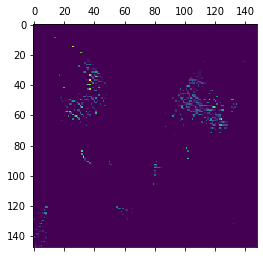

In [11]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

### 코드 5-30 16번째 채널 시각화

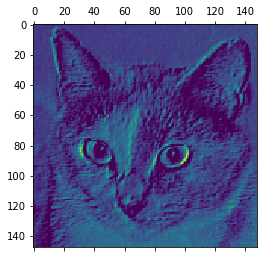

In [23]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

### 중간층의 모든 활성화에 있는 채널 시각화

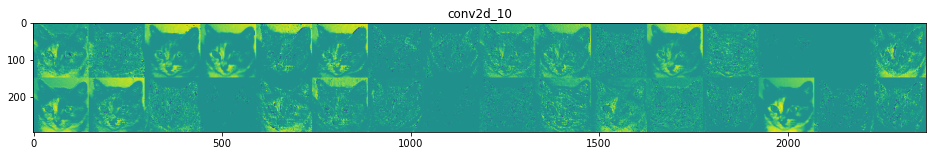

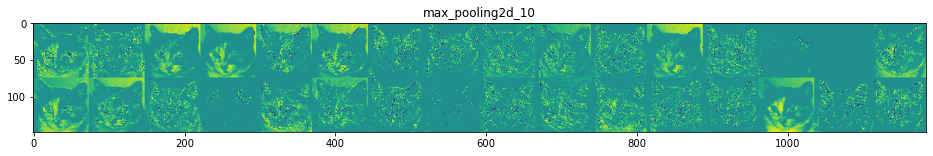

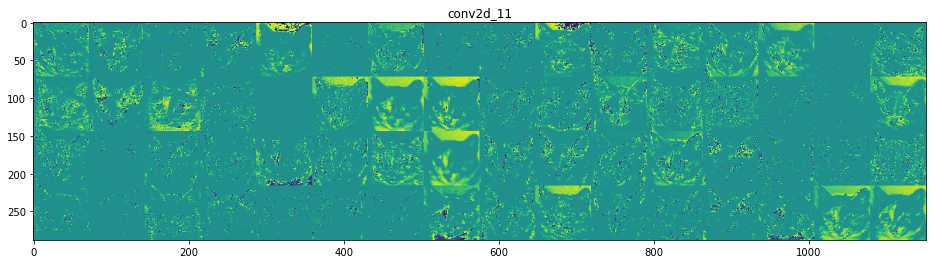

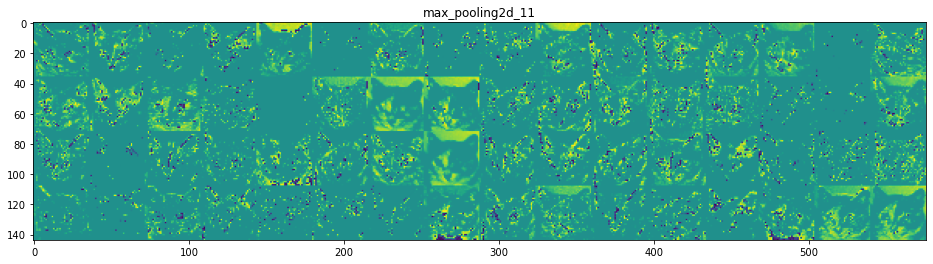

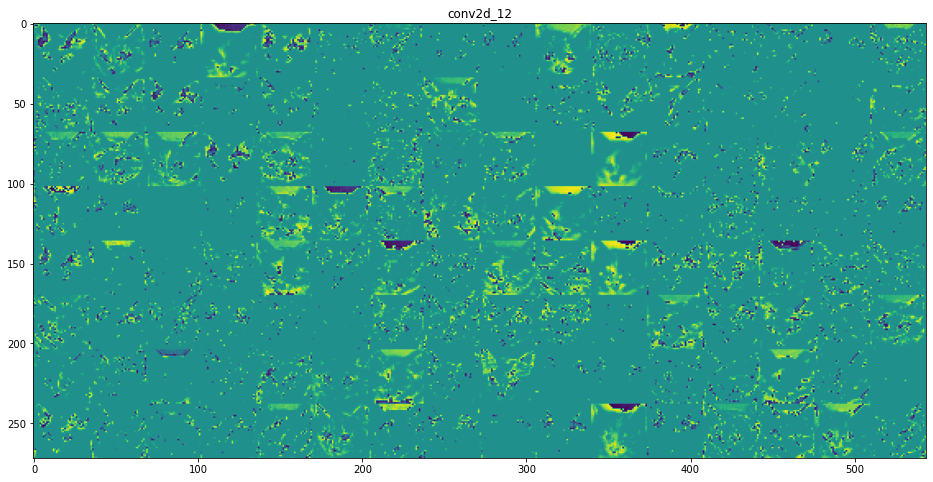

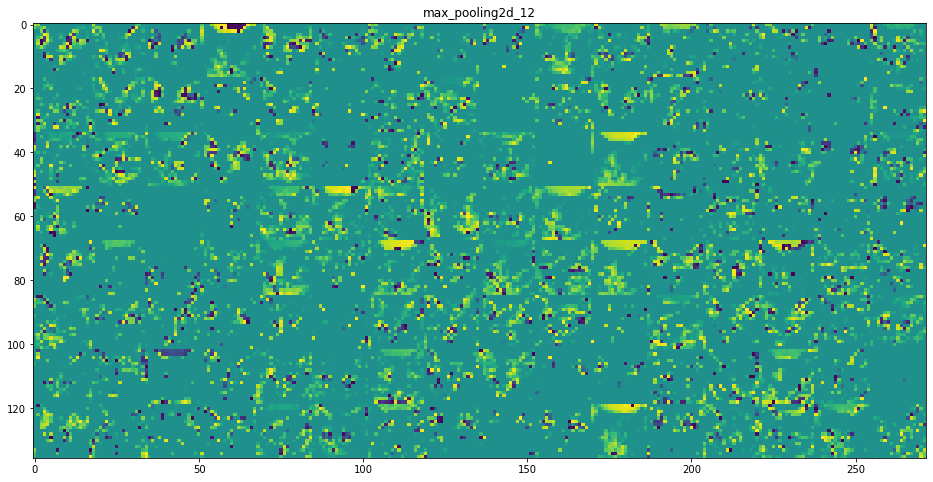

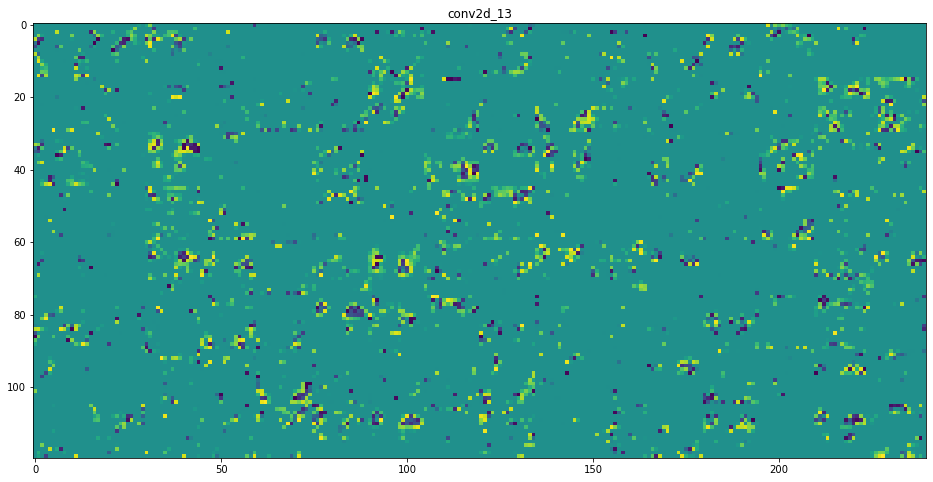

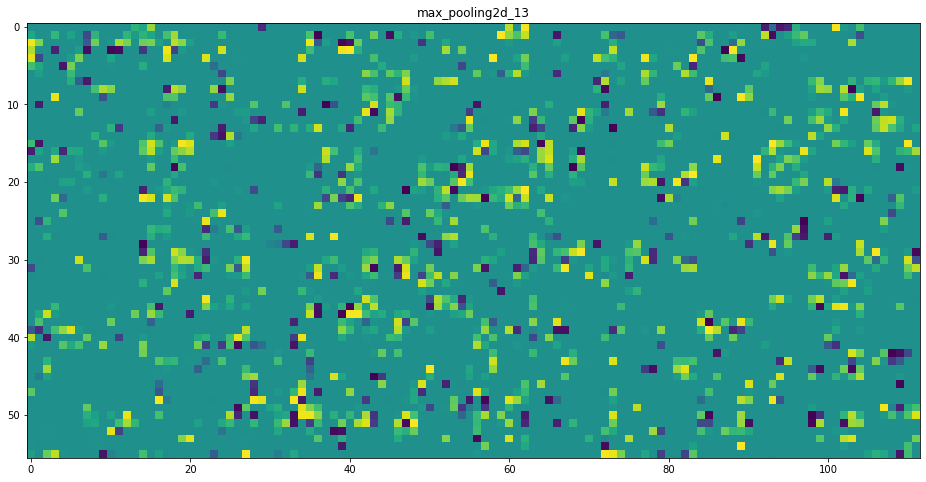

In [30]:
# 층의 이름을 그래프 제목으로 사용
layer_names = list()
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

# 피처 맵 그림
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean() # 그래프로 나타내기 좋게 피처 처리
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image = np.clip(channel_image, 0, 255).astype('int8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image
            
        
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()
            
    

### 5.2.4 컨브넷 필터 시각화

In [47]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 코드 5-33 입력에 대한 손실의 그래디언트 구하기

In [48]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, model.input)[0] # gradients 함수가 반환하는 텐서 리스트

### 코드 5-34 그래디언트 정규화

경사 상승법 과정을 부드럽게 하기 위해 그래디언트 텐서를 L2 노름(텐서에 있는 값을 제곱한 합의 제곱근)으로 나누어 정규화<br>
이렇게 할 경우 입력 이미지에 적용할 수정량의 크기를 항상 일정 범위 안에 놓을 수 있음

In [50]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) 
# 0 나눗셈 방지를 위해 1e -5 를 더함

### 코드 5-35 입력 값에 대한 넘파이 출력 값 추출

In [52]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

파이썬 루프를 만들어 확률적 경사 상승법 구성

### 코드 5-36 확률적 경사 상승법을 사용한 손실 최대화

In [53]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    # 손실을 최대화 하는 방향으로 입력 이미지 수정
    input_img_data += grads_value * step

### 